# Correlation with clinical outcome - BeatAML

The evaluation of the merged Palma-Ikonomi models focuses on their ability to predict clinical outcomes for patients with specific mutations. Palma et al. has connected their network to three cancer hallmark phenotypes: apoptosis, differentiation and proliferation. In addition, an integrated network score was defined as subtracting the value of apoptosis and differentiation from the value of the proliferation to reflect the malignancy of the cancer. The phenotype scores were then used as a proxy of the prediction power of the model to patients’ clinical outcomes.

Here, BeatAML data is used in this analysis for the blast percentage patient data.

In [62]:
model1name = "Palma2021"
model2name = "Ikonomi2020"

## Data - BeatAML
805 patients (942 specimens) in total. 
> For DNA sequencing, we used the 11.9 megabase custom capture library that was developed to provide coverage of all variants previously reported in AML (including all variants that were detected from exome sequencing in our prior study).

Mutation, clinical data and drug response data are downloaded from the [BeatAML2 website](https://biodev.github.io/BeatAML2/):
1. [WES/targeted Sequencing Mutation Calls](https://github.com/biodev/beataml2.0_data/raw/main/beataml_wes_wv1to4_mutations_dbgap.txt)
2. [Clinical Summary](https://github.com/biodev/beataml2.0_data/raw/main/beataml_wv1to4_clinical.xlsx)
3. [Inhibitor AUC values](https://github.com/biodev/beataml2.0_data/raw/main/beataml_probit_curve_fits_v4_dbgap.txt)
4. [Inhibitor Families](https://github.com/biodev/beataml2.0_data/raw/main/beataml_drug_families.xlsx)

## Methods
Similar to the approach used in Palma et al., we first set the fix values of the models according to the 8 mutation profiles (mutation status of FLT3, NPM1 and DNMT3A). And then run simulations using the `biolqm.fixpoints` function from `BoolNet` to compute the complete list of logical stable states (or fixpoints) of the model.   

Using the stable states, the phenotype scores can be calculated as:
- Apoptosis = tp53 - bcl2
- Differentiation =	cebpa + etv6 - meis1
- Proliferation	= myc + ccnd1 + sox4 + meis1 + stat5a
- Network = Proliferation - Differentiation - Apoptosis 

Then we correlate the derived network scores with the blast percentage in peripheral blood (PB_blast) and bone marrow (BM_blast) of patients from the BeatAML dataset.  


In [63]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations, chain  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
import xml.etree.ElementTree as ET # for parse the SBML file
import seaborn as sns # for plotting
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy import stats
from matplotlib.gridspec import GridSpec

In [64]:
home = "persistent/" # home path for Logic Model Merger
model1 = biolqm.load(home + "LogicModelMerger/Models/" + model1name + ".sbml")
model2 = biolqm.load(home + "LogicModelMerger/Models/" + model2name + ".sbml")
merged_and = biolqm.load(home + "LogicModelMerger/Models/merged_and_" + model1name + "_" + model2name + ".sbml")
merged_inhibitor_wins = biolqm.load(home + "LogicModelMerger/Models/merged_inhibitor_wins_" + model1name + "_" + model2name + ".sbml")
merged_or = biolqm.load(home + "LogicModelMerger/Models/merged_or_" + model1name + "_" + model2name + ".sbml")

In [66]:
# Get genes in each model
def getnodes(model_name):
    # Load and parse the SBML file
    tree = ET.parse(home + "LogicModelMerger/Models/" + model_name + ".sbml")
    root = tree.getroot()
    
    # Define the namespace for SBML Level 3 Version 1 Core and Qual
    ns = {
        'sbml': 'http://www.sbml.org/sbml/level3/version1/core',
        'qual': 'http://www.sbml.org/sbml/level3/version1/qual/version1'
    }
    
    # Find all qualitativeSpecies in the model
    qual_species_list = root.findall('.//qual:qualitativeSpecies', ns)
    
    # Extract the IDs of the qualitativeSpecies
    qual_species_ids = []
    for species in qual_species_list:
        species_id = species.attrib.get('{http://www.sbml.org/sbml/level3/version1/qual/version1}id')
        if species_id:
            qual_species_ids.append(species_id)

    print(qual_species_ids)
    return qual_species_ids
    
gene_model1 = getnodes(model1name)
gene_model2 = getnodes(model2name)
gene_merged = list(set(gene_model1 + gene_model2))

['FLT3', 'NPM1', 'AKT1', 'APOPTOSIS', 'BCL2', 'CCND1', 'CDKN2A', 'CEBPA', 'DIFFERENTIATION', 'DNMT3A', 'MAPK1', 'ETV6', 'FBXW7', 'GSK3B', 'HOXA9', 'MEIS1', 'MYC', 'PROLIFERATION', 'SOX4', 'STAT5A', 'TP53']
['EXTERNAL_QUIESCENCE', 'EXTERNAL_CYCLING', 'PIK3CA', 'TSC1', 'MTOR', 'FOXO3', 'ATM', 'ROS1', 'MITOCHONDRIA', 'AUTOPHAGY', 'NRAS', 'ETS1', 'MEFV', 'GSK3B', 'CTNNB1', 'MYC', 'BMI1', 'MDM2', 'TP53', 'CDKN1C', 'CDKN1A', 'CDKN1B', 'GFI1', 'RB1', 'E2F1', 'CCND1', 'CCNE1', 'S_PHASE', 'AKT1', 'CDKN2D', 'CDKN2A', 'PRO_APOPTOTIC_PROTEINS', 'ANTI_APOPTOTIC_PROTEINS', 'CYCS', 'APOPTOSIS', 'SENESCENCE']


In [67]:
# Function to determine mutation combination
def determine_combination(row):
    genes = row['symbol']
    has_flt3 = 'FLT3' in genes
    has_npm1 = 'NPM1' in genes
    has_dnmt3a = 'DNMT3A' in genes

    if has_flt3 and has_npm1 and has_dnmt3a:
        return "FLT3_NPM1_DNMT3A"
    elif has_flt3 and has_dnmt3a:
        return "FLT3_DNMT3A"
    elif has_flt3 and has_npm1:
        return "FLT3_NPM1"
    elif has_npm1 and has_dnmt3a:
        return "NPM1_DNMT3A"
    elif has_flt3:
        return "FLT3"
    elif has_npm1:
        return "NPM1"
    elif has_dnmt3a:
        return "DNMT3A"
    else:
        return "WT"

In [68]:
# Pre-process of the BeatAML data
mutations = pd.read_csv("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wes_wv1to4_mutations_dbgap.txt", sep='\t')
clinical = pd.read_excel("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wv1to4_clinical.xlsx")

clinical = clinical[
    (clinical['dxAtSpecimenAcquisition'] == 'ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PRECURSOR NEOPLASMS') |
    (clinical['dxAtSpecimenAcquisition'] == 'ACUTE LEUKAEMIAS OF AMBIGUOUS LINEAGE')
]
clinical_df = pd.merge(mutations, clinical[['dbgap_subject_id', 'dbgap_dnaseq_sample','FLT3-ITD','NPM1']], left_on='dbgap_sample_id', right_on='dbgap_dnaseq_sample')

# Add FLT3-ITD
flt3_positive_df = clinical_df[clinical_df['FLT3-ITD'] == 'positive'].copy()
flt3_positive_df['symbol'] = 'FLT3'

# Add NPM1
npm1_positive_df = clinical_df[clinical_df['NPM1'] == 'positive'].copy()
npm1_positive_df['symbol'] = 'NPM1'

result_df = pd.concat([clinical_df, flt3_positive_df, npm1_positive_df], ignore_index=True)

In [70]:
# Identify the mutation profile of each patient
grouped = result_df.groupby('dbgap_subject_id').agg(list).reset_index()
grouped['mutation'] = grouped.apply(determine_combination, axis=1)

# Merge the gene information with the clinical data
clinical_result = pd.merge(clinical, grouped[['dbgap_subject_id', 'mutation']], on='dbgap_subject_id')
clinical_result['survivalYears'] = clinical_result['ageAtDiagnosis'] + clinical_result['overallSurvival']/365
clinical_result = clinical_result[['dbgap_subject_id', 'mutation', '%.Blasts.in.BM', '%.Blasts.in.PB', 'survivalYears']]

# convert to numeric
clinical_result['%.Blasts.in.BM'] = pd.to_numeric(clinical_result['%.Blasts.in.BM'], errors='coerce')
clinical_result['%.Blasts.in.PB'] = pd.to_numeric(clinical_result['%.Blasts.in.PB'], errors='coerce')

# aggregate the mean PB of each mutation profile
clinical_aggr = clinical_result.pivot_table(
    index='mutation', 
    values=['%.Blasts.in.BM','%.Blasts.in.PB','survivalYears'],
    aggfunc='mean'
)
clinical_aggr.columns = ['BM_BLAST', 'PB_BLAST','Survival']

# save the clinical file
clinical_aggr.to_csv(home + "LogicModelMerger/Data/BeatAML/clinical.csv")
clinical_aggr

,BM_BLAST,PB_BLAST,Survival
mutation,,,
DNMT3A,41.224590,44.661111,65.143983
FLT3,69.519277,55.226923,57.285853
FLT3_DNMT3A,64.387500,53.947368,63.542564
FLT3_NPM1,81.525862,69.364151,59.126350
FLT3_NPM1_DNMT3A,67.064286,58.534091,58.851408
NPM1,64.609756,54.592000,58.598427
NPM1_DNMT3A,58.327586,31.810000,60.901723
WT,52.732919,39.472314,58.280578


In [71]:
# Simulate the models for each mutation profile and return the phenotype scores
def simulation(model):
    
    # set the fix value for the simulations
    wt = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%1")
    flt3 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%1")
    npm1 = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%0")
    dnmt3a = biolqm.perturbation(model, "FLT3%0 DNMT3A%0 NPM1%1")
    npm1_dnmt3a = biolqm.perturbation(model,"FLT3%0 DNMT3A%0 NPM1%0")
    flt3_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%1")
    flt3_npm1 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%0")
    flt3_npm1_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%0")

    # get the stable states
    networks = [wt,flt3,npm1,dnmt3a,npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_npm1_dnmt3a]
    results = pd.DataFrame()
    for network in networks:
        fps = biolqm.fixpoints(network)
        # take average if multiple stable states exist
        results = pd.concat([results, pd.DataFrame(fps).mean().to_frame().T],ignore_index=True)
    results.index = ["WT","FLT3","NPM1","DNMT3A","NPM1_DNMT3A","FLT3_DNMT3A","FLT3_NPM1","FLT3_NPM1_DNMT3A"]
    
    # calculate the phenotype scores
    results['APOPTOSIS'] = results['TP53'] - results['BCL2']
    results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
    results['PROLIFERATION'] = results['MYC'] + results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
    
    # calculate the network scores
    results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
    simulation_results = results.T.sort_index()
    return simulation_results


# Plot the correlation
def clinical_plot(simulation_results, clinical_file):
    clinical_aggr = pd.read_csv(clinical_file,index_col=0)
    clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),simulation_results.sort_index(axis=1)])
    
    # Plotting scatterplots
    clinicals = ['PB_BLAST', 'BM_BLAST']
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    for i, clinical in enumerate(clinicals):
        ax = axes[i]
        # Extract network scores and clinical outcome values
        x = clinical_results.loc['NETWORK', :]
        y = clinical_results.loc[clinical, :]
        
        # Calculate Pearson Correlation and p-value
        pc, p_value = pearsonr(x, y)
    
        # Linear regression (best-fit line)
        slope, intercept = np.polyfit(x, y, 1)
        ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
        
        # Create scatterplot
        ax.scatter(x, y)
        ax.set_title(f'{clinical} vs Network score')
        ax.set_xlabel('Network score')
        ax.set_ylabel('%' + clinical)
    
            # Annotate each data point
        for j in range(len(x)):
            label = x.index[j]
            ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')
    
        
        # Annotate Pearson Correlation and p-value
        ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                transform=ax.transAxes, horizontalalignment='right')
        
    plt.tight_layout()
    plt.show()

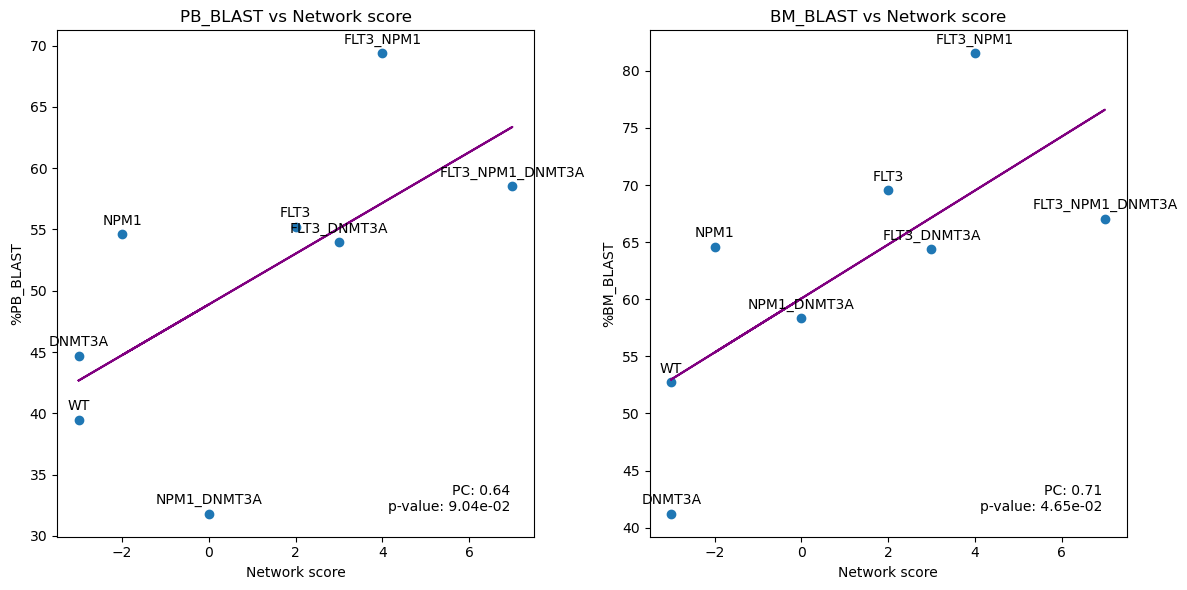

In [72]:
# The Palma results
simulation_results_1 = simulation(model1)
clinical_plot(simulation_results_1, home + "LogicModelMerger/Data/BeatAML/clinical.csv")

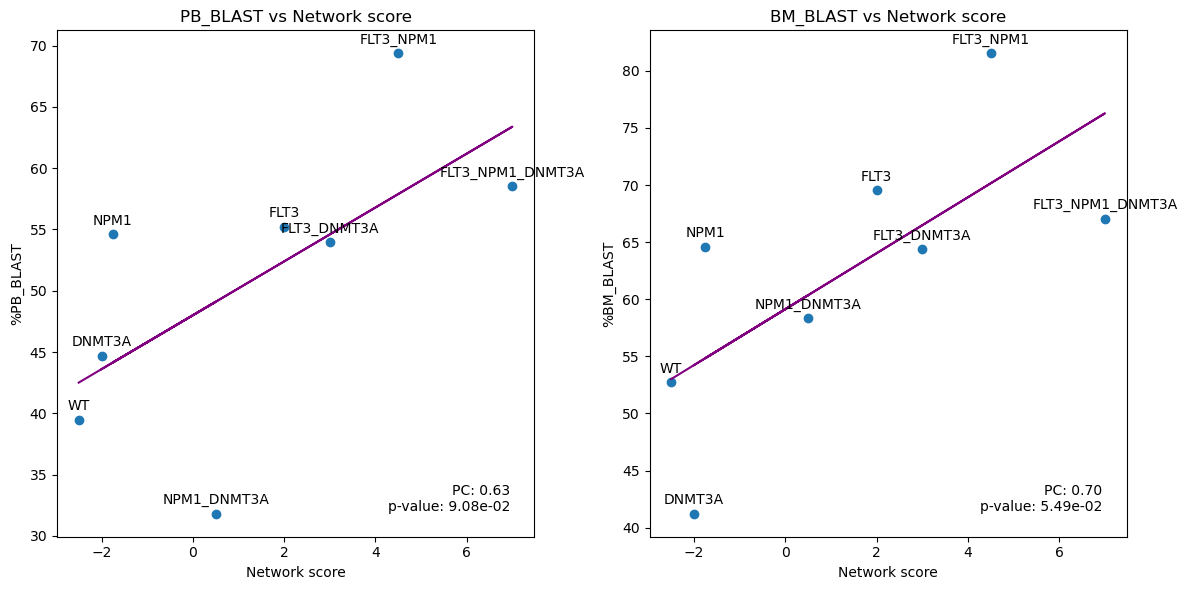

In [73]:
# Merged rules using 'OR'
simulation_results_or = simulation(merged_or)
clinical_plot(simulation_results_or, home + "LogicModelMerger/Data/BeatAML/clinical.csv")

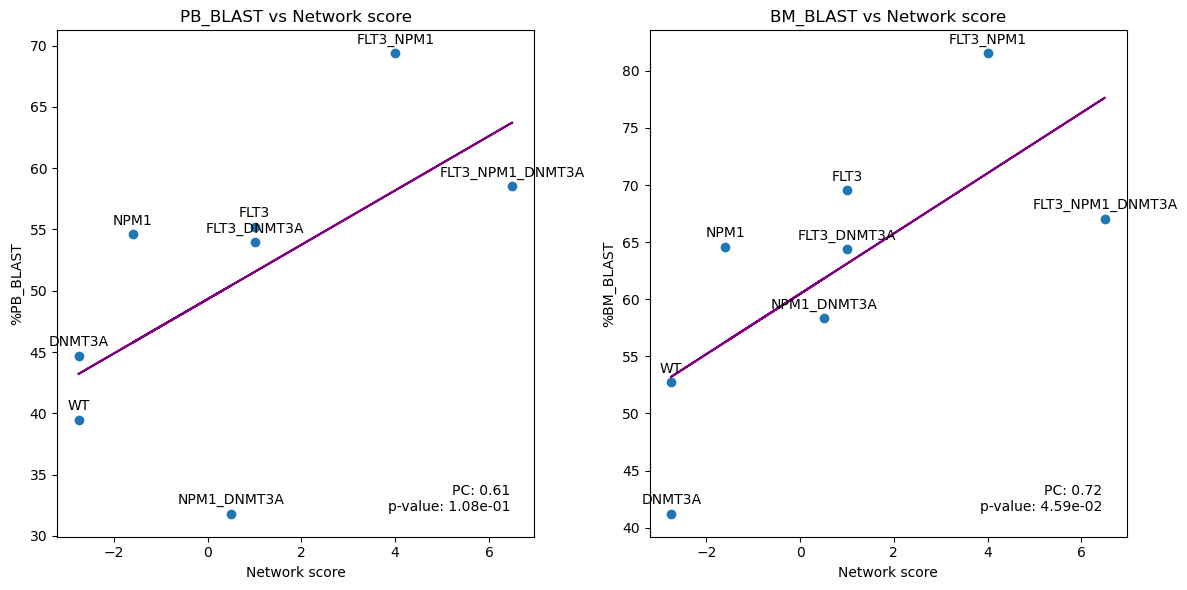

In [74]:
# Merged rules using 'Inhibitor wins'
simulation_results_inhibitor_wins = simulation(merged_inhibitor_wins)
clinical_plot(simulation_results_inhibitor_wins, home + "LogicModelMerger/Data/BeatAML/clinical.csv")

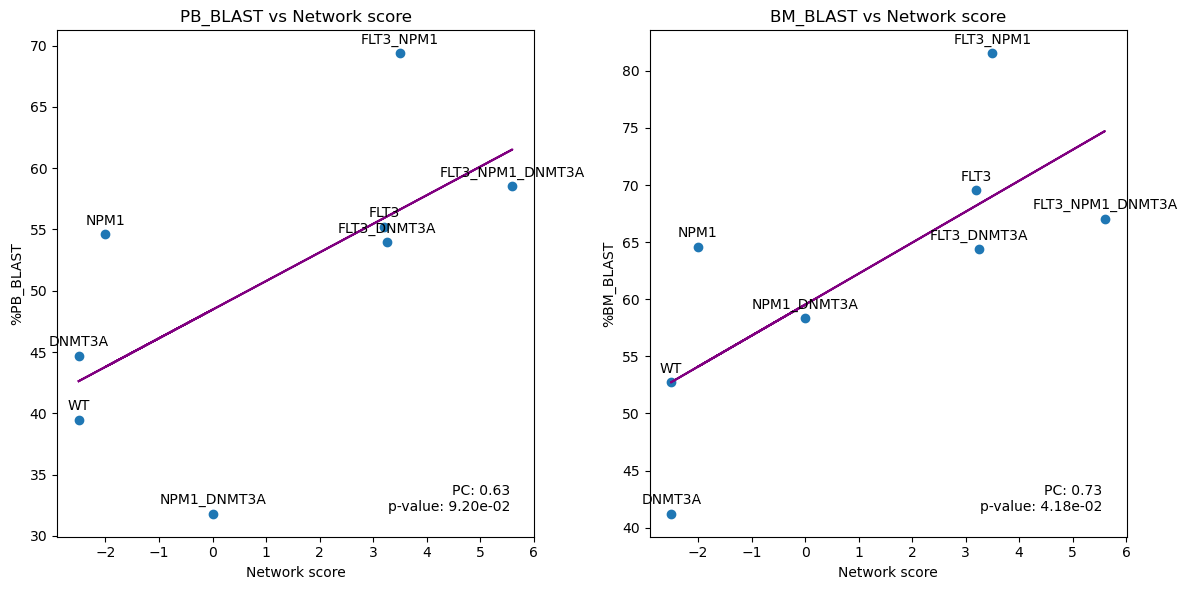

In [75]:
# Merged rules using 'AND'
simulation_results_and = simulation(merged_and)
clinical_plot(simulation_results_and, home + "LogicModelMerger/Data/BeatAML/clinical.csv")

## Conclusion
In general, we achieved comparable results across two datasets (BeatAML, the new dataset and TCGA-LAML, dataset used in the original study), both for the original model and the merged model.